# Model TCNN Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## Settings notebook

In [1]:
mode_collect = True # True : retrieve data online (set TRAIN_SPLIT in model_kr)
mode_train = True # True : Train model
mode_cross_valid = False # True : try several models

## import

In [2]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary

from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
tf.test.gpu_device_name()

''

In [6]:
tf.test.is_built_with_cuda()

False

In [7]:
tf.test.is_built_with_gpu_support()

False

In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 830238522749949412]

## Definitions

In [9]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr_tcn"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot
list_feat = ['T_min', 'T_max', 'H_min', 'H_max', 'pos', 'test', 'day_num',
                                           'age_pos', 'age_test']

##  Helper functions

In [10]:
# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [11]:
if mode_collect:
    get_data_pos()
df_feat_fr = load_data_pos()

No new data meteo


## Retrieve old data

In [12]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [13]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-09-26  289.327966  2021-09-26  295.911017  63.152542  93.118644     0.0   
2021-09-27  287.765000  2021-09-27  295.293333  59.216667  92.000000     0.0   
2021-09-28  286.375000  2021-09-28  293.993333  58.983333  90.233333     0.0   
2021-09-29  286.875000  2021-09-29  293.856667  55.383333  88.766667     0.0   
2021-09-30  284.388333  2021-09-30  292.543333  57.416667  88.200000     0.0   

             pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                           
2020-05-13   881  61.104427   39013  55.451567        3    141108        NaN   
2020-05-14   981  60.403670   41975  54.832186        4    142089        NaN   
2020-05-15  1019  60.063788   47596  54.404446        5    143108        NaN   
2020-05-16   291  60.020619   16523  54.480058        6    143399        NaN   
2020-05-17   141  61.248227    6611  58.226895        0    143540        NaN   
...          ...        ...     ...        ...      ...       ...        ...   
2021-09-26  1114  41.244165  100587  42.809677        0   6914879    86104.0   
2021-09-27  7466  40.135548  556021  43.227554        1   6922345    81997.0   
2021-09-28  5443  40.472717  472517  41.694517        2   6927788    79168.0   
2021-09-29  4971  39.492456  422979  42.556555        3   6932759    76406.0   
2021-09-30  4801  40.963549  511877  39.266591        4   6937560    74104.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.258222  
2020-05-14       NaN  2.337105  
2020-05-15       NaN  2.140936  
2020-05-16       NaN  1.761181  
2020-05-17       NaN  2.132809  
...              ...       ...  
2021-09-26  0.549098  1.107499  
2021-09-27  0.560663  1.342755  
2021-09-28  0.572139  1.151916  
2021-09-29  0.582932  1.175236  
2021-09-30  0.591828  0.937921  

[506 rows x 15 columns]

In [14]:
if mode_collect:
    # keep 25 Validation samples:
    #TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    TRAIN_SPLIT = round(0.8*df_feat_fr.shape[0])
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 405


In [15]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-09-26  289.327966  2021-09-26  295.911017  63.152542  93.118644     0.0   
2021-09-27  287.765000  2021-09-27  295.293333  59.216667  92.000000     0.0   
2021-09-28  286.375000  2021-09-28  293.993333  58.983333  90.233333     0.0   
2021-09-29  286.875000  2021-09-29  293.856667  55.383333  88.766667     0.0   
2021-09-30  284.388333  2021-09-30  292.543333  57.416667  88.200000     0.0   

             pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                           
2020-05-13   881  61.104427   39013  55.451567        3    141108        NaN   
2020-05-14   981  60.403670   41975  54.832186        4    142089        NaN   
2020-05-15  1019  60.063788   47596  54.404446        5    143108        NaN   
2020-05-16   291  60.020619   16523  54.480058        6    143399        NaN   
2020-05-17   141  61.248227    6611  58.226895        0    143540        NaN   
...          ...        ...     ...        ...      ...       ...        ...   
2021-09-26  1114  41.244165  100587  42.809677        0   6914879    86104.0   
2021-09-27  7466  40.135548  556021  43.227554        1   6922345    81997.0   
2021-09-28  5443  40.472717  472517  41.694517        2   6927788    79168.0   
2021-09-29  4971  39.492456  422979  42.556555        3   6932759    76406.0   
2021-09-30  4801  40.963549  511877  39.266591        4   6937560    74104.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.258222   True  
2020-05-14       NaN  2.337105   True  
2020-05-15       NaN  2.140936   True  
2020-05-16       NaN  1.761181   True  
2020-05-17       NaN  2.132809   True  
...              ...       ...    ...  
2021-09-26  0.549098  1.107499  False  
2021-09-27  0.560663  1.342755  False  
2021-09-28  0.572139  1.151916  False  
2021-09-29  0.582932  1.175236  False  
2021-09-30  0.591828  0.937921  False  

[506 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

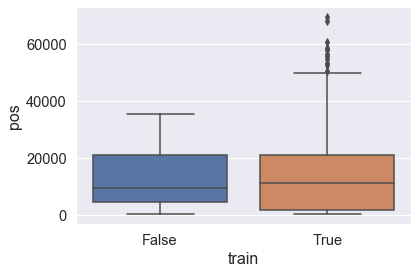

In [16]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

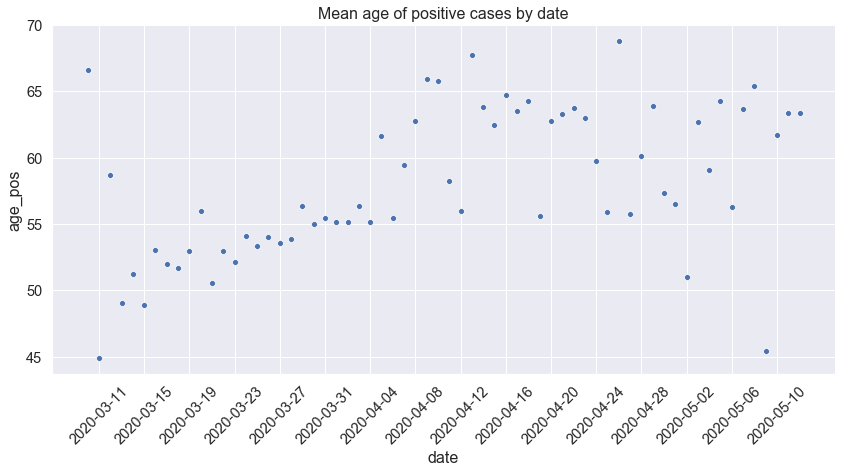

In [17]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

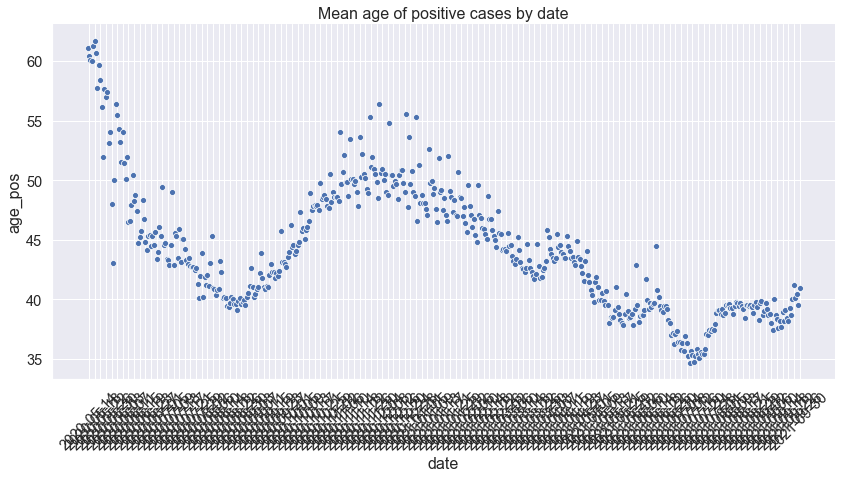

In [18]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

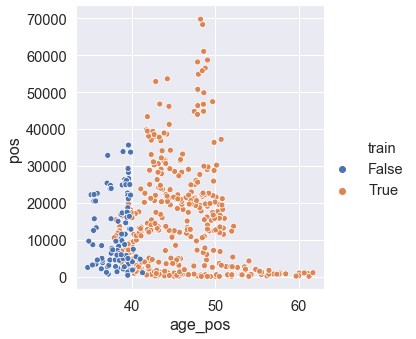

In [19]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

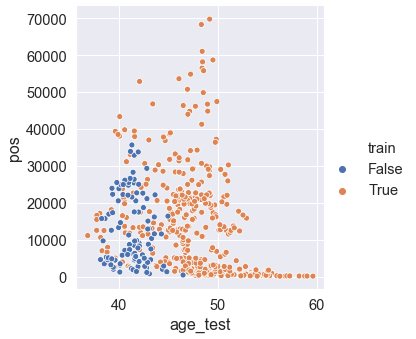

In [20]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

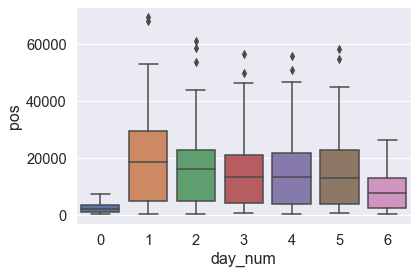

In [21]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [22]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

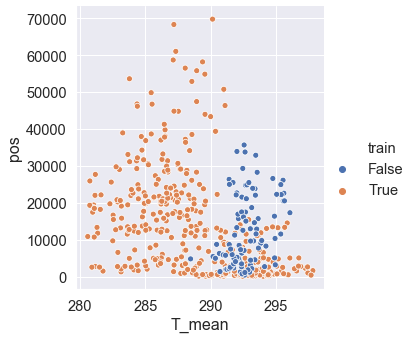

In [23]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

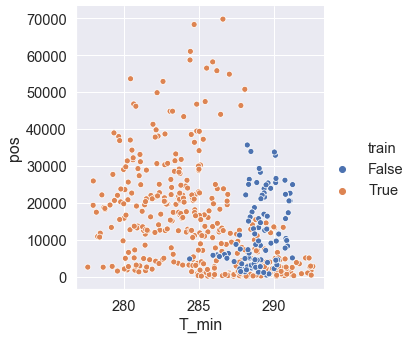

In [24]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

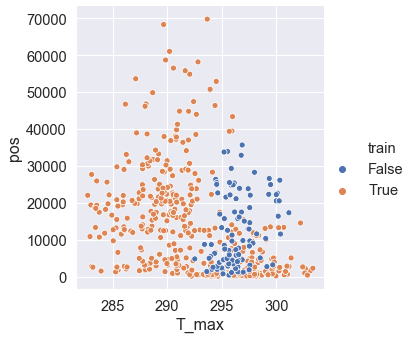

In [25]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

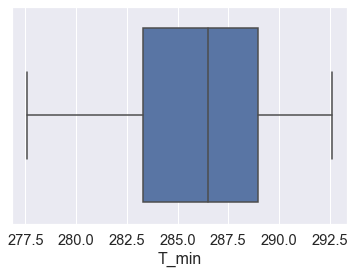

In [26]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [27]:
df_feat_fr["T_min"].mean()

286.02675277305394

In [28]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    271
True     235
Name: T_min, dtype: int64

In [29]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     253
False    253
Name: T_min, dtype: int64

In [30]:
df_feat_fr["T_min"].median()

286.51666666666665

In [31]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

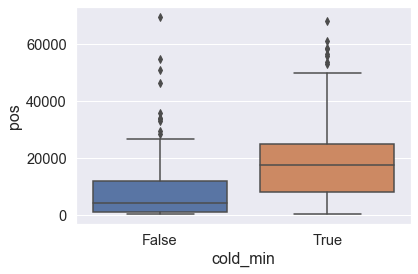

In [32]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

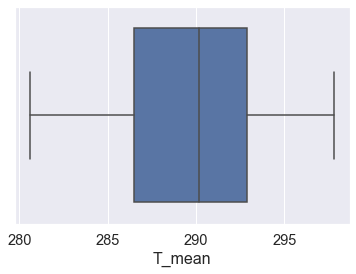

In [33]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [34]:
df_feat_fr["T_mean"].median()

290.16541666666666

In [35]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

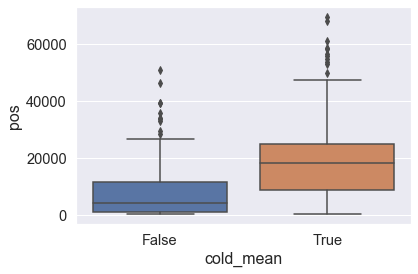

In [36]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

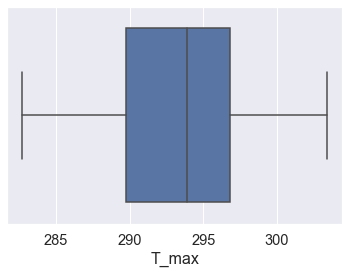

In [37]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [38]:
df_feat_fr["T_max"].median()

293.86583333333334

In [39]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

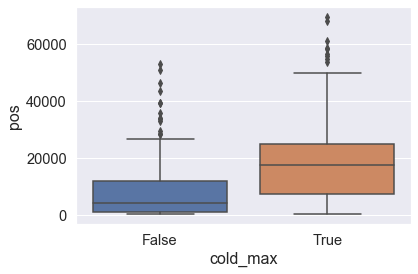

In [40]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [41]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

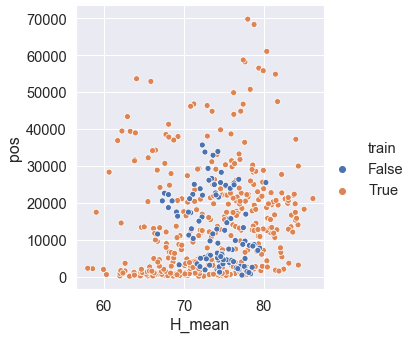

In [42]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

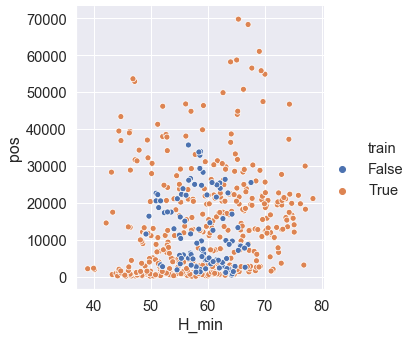

In [43]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

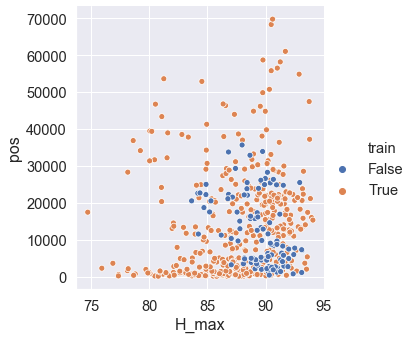

In [44]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

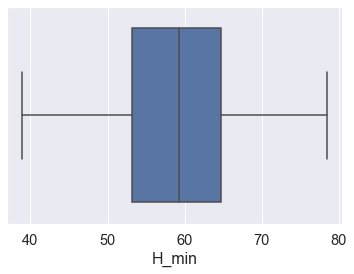

In [45]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [46]:
df_feat_fr["H_min"].median()

59.2311403508772

In [47]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

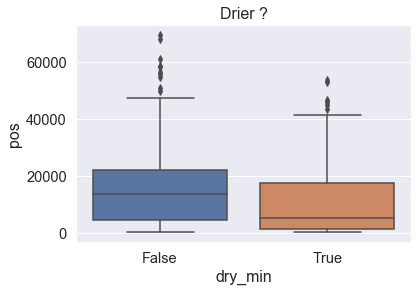

In [48]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)
ax.set_title("Drier ?");

=> DRIER, less positive cases

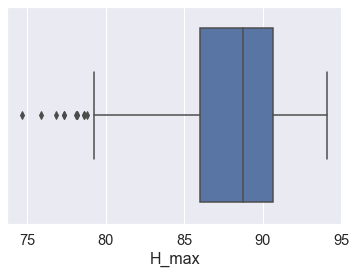

In [49]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [50]:
df_feat_fr["H_max"].median()

88.76666666666668

In [51]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

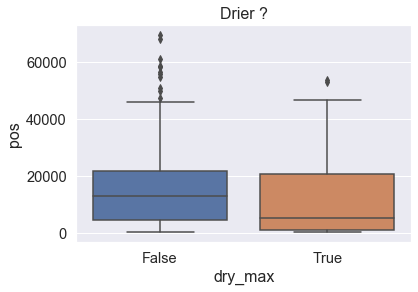

In [52]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)
ax.set_title("Drier ?");

=> => Same than H min

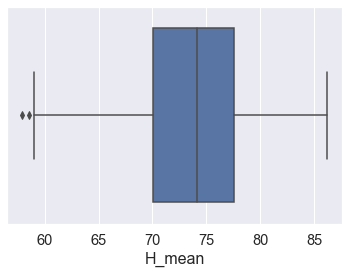

In [53]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [54]:
df_feat_fr["H_mean"].median()

74.125

In [55]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

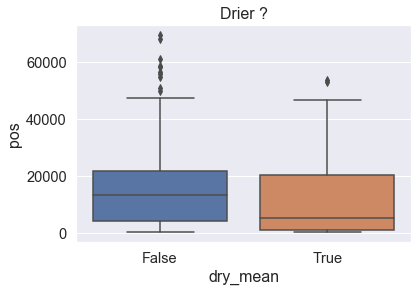

In [56]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)
ax.set_title("Drier ?");

=> Same H min

### Seasonality impact

In [57]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

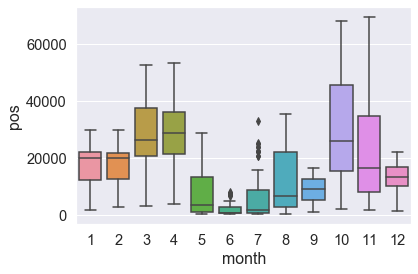

In [58]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

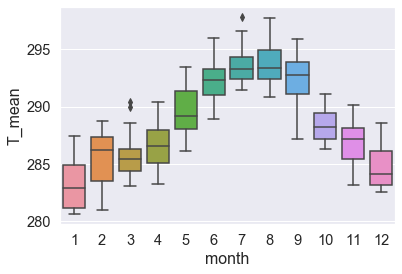

In [59]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

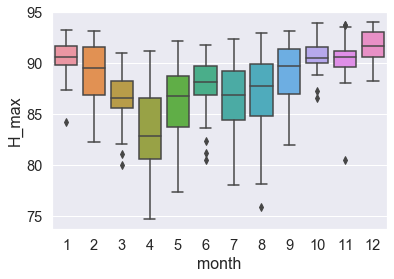

In [60]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [61]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1      526559
2      495384
3      831057
4      815262
5      372421
6      112326
7      393751
8      733653
9      520444
10     932530
11     671029
12     392917

### Nb Tested

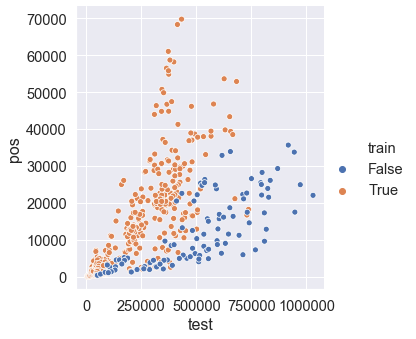

In [62]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [63]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [64]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [65]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [66]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max   pos    test  \
date                                                                     
2020-05-13  284.926667  290.505000  64.661017  88.135593   881   39013   
2020-05-14  285.050000  290.963333  59.406780  84.847458   981   41975   
2020-05-15  285.308333  291.920000  57.372881  82.966102  1019   47596   
2020-05-16  284.956667  293.500000  53.741379  86.534483   291   16523   
2020-05-17  285.598333  294.446667  49.879310  85.500000   141    6611   
...                ...         ...        ...        ...   ...     ...   
2021-09-26  289.327966  295.911017  63.152542  93.118644  1114  100587   
2021-09-27  287.765000  295.293333  59.216667  92.000000  7466  556021   
2021-09-28  286.375000  293.993333  58.983333  90.233333  5443  472517   
2021-09-29  286.875000  293.856667  55.383333  88.766667  4971  422979   
2021-09-30  284.388333  292.543333  57.416667  88.200000  4801  511877   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.104427  55.451567  
2020-05-14        4  60.403670  54.832186  
2020-05-15        5  60.063788  54.404446  
2020-05-16        6  60.020619  54.480058  
2020-05-17        0  61.248227  58.226895  
...             ...        ...        ...  
2021-09-26        0  41.244165  42.809677  
2021-09-27        1  40.135548  43.227554  
2021-09-28        2  40.472717  41.694517  
2021-09-29        3  39.492456  42.556555  
2021-09-30        4  40.963549  39.266591  

[506 rows x 9 columns]

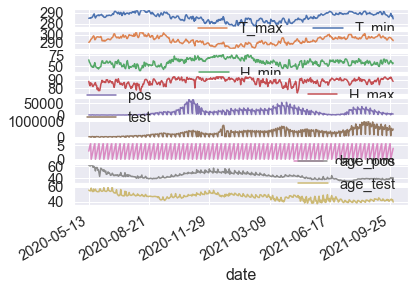

In [67]:
features.plot(subplots=True);

In [68]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [69]:
dataset.shape

(506, 9)

## Multi-step model

### Helper functions

In [70]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def grads_by_days(x_train_multi, multi_step_model):
    '''
    Calculate gradients over Features and days before (mean over sequence) 
    : Nb Days before x Nb Features
    '''
    sum_grads = None
    for i_seq in range(x_train_multi.shape[0]):
        seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], 
                          dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = multi_step_model(seq)

        grads = tape.gradient(predictions, seq)
        if sum_grads is None:
            sum_grads = grads.numpy()[0]
        else:
            sum_grads = +grads.numpy()[0]

    sum_grads = sum_grads / x_train_multi.shape[0]

    return sum_grads

def grads_by_features(x_train_multi, multi_step_model):
    '''
    Calculate gradients by feature : (Nb seq input x Nb Feature)
    '''
    arr_grads = None
    for i_seq in range(x_train_multi.shape[0]):
        seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], 
                          dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = multi_step_model(seq)

        grads = tape.gradient(predictions, seq)
        grads = tf.reduce_mean(grads, axis=1).numpy()[0]

        if arr_grads is None:
            arr_grads = grads
        else:
            arr_grads = np.vstack((arr_grads, grads))
    return arr_grads


### data 14D_to_7D

In [71]:
TRAIN_SPLIT

405

In [72]:
dataset.shape

(506, 9)

In [73]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [74]:
y_train_multi.shape

(391, 7)

In [75]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target future to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

391 Single window of past history : (14, 9)

 391 Target future to predict : (7,)


In [76]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 391
BUFFER_SIZE : 405

For validation : 
BATCH_SIZE_VAL : 94


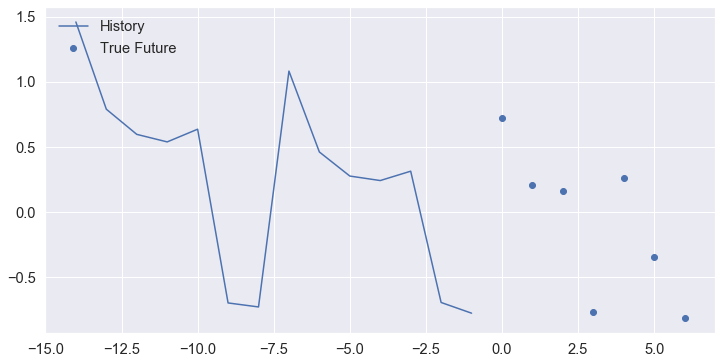

In [77]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [78]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 391
nb samples for validation : 94


In [79]:
x_train_multi.shape[-2:]

(14, 9)

#### No skip connexion / internat dropout 0.4 / dropout last layer 0.4

In [80]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    # Hyper-parameters
    # lr=6e-2, decay = 1e-6, momentum = 0.9,  nesterov = True, patience = 250
    # Final val_loss = 0.18278686702251434
    # Mean asbolute Error in people : 2587.2852865276022
    # Mac : CPU times: user 1h 50min 6s, sys: 43min 33s, total: 2h 33min 39s
    # Mac : Wall time: 1h 22min 11s
    #
    # 100 TRIES / EPOCHS 5000
    # lr = 2e-2 decay = 1e-6 momentum = 0.9 nesterov = True patience = 250
    # Final val_loss = 0.13554999232292175
    # Mean asbolute Error in people : 1901.908237664341
    # Wall time: 29min 44s GPU
    
    #lr = 2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    
    
    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4], 
            dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        out_tcn = Dropout(0.4)(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


In [81]:
if mode_cross_valid:
    # online version before 24/06/2021: 
    #Train Mean Error  [nb of cases]:  4796.392175023473
    #Val. Mean Error  [nb of cases]:  5321.471272441916
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.14513288352582
    # new 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

#### No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4

In [82]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4], 
            dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        out_tcn = Dropout(0.4)(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [83]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

In [84]:
if mode_cross_valid:
    tcn_full_summary(multi_step_model, expand_residual_blocks=True)

#### No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4 - check

In [85]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        out_tcn = Dropout(0.4)(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [86]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

In [87]:
if mode_cross_valid:
    tcn_full_summary(multi_step_model, expand_residual_blocks=True)

#### No skip connexion / internal dropout 0.05 /  dropout before dense 0.4

In [88]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [89]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

#### used  skip connexion / dropout int 0.05 out 0.4 

In [90]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs


In [91]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

In [92]:
if mode_cross_valid:
    tcn_full_summary(multi_step_model, expand_residual_blocks=True)

#### used  skip connexion / dropout int 0.4 out 0.4 

In [93]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [94]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

#### used  skip connexion / dropout int 0.4 out 0.4 / layer norm

In [95]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      use_layer_norm=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11 µs


In [96]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

#### used  skip connexion / dropout int 0.4 out 0.4 / batch norm

In [97]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      use_batch_norm=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs


In [98]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

#### used  skip connexion / dropout int 0.3 out 0.3

In [99]:
%%time

if mode_train & mode_cross_valid:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.3)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.3)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 12.2 µs


In [100]:
if mode_cross_valid:
    # new ref : 24/06/2021
    #Train Mean Error  [nb of cases]:  4691.218482315059
    #Val. Mean Error  [nb of cases]:  5361.96017213067
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  31.382103468642846
    # version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
    #Train Mean Error  [nb of cases]:  4434.365795614253
    #Val. Mean Error  [nb of cases]:  5650.963417076767
    #Val. Mean nb cases  [nb of cases]:  17086.04452690167
    #Val. Mean Relative Error [%]:  33.07356133936925

    y_train_multi_pred = multi_step_model.predict(x_train_multi)
    mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                       y_train_multi_pred)
    print("Train Mean Error  [nb of cases]: ", mean_error_train)
    y_val_multi_pred = multi_step_model.predict(x_val_multi)
    mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                       y_val_multi_pred)

    print("Val. Mean Error  [nb of cases]: ", mean_error_val)
    mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
    print("Val. Mean nb cases  [nb of cases]: ", mean_val)
    print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

#### used  skip connexion / dropout int 0.5 out 0.1


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01339: early stopping
Run #0 : val_loss = 0.4383651614189148


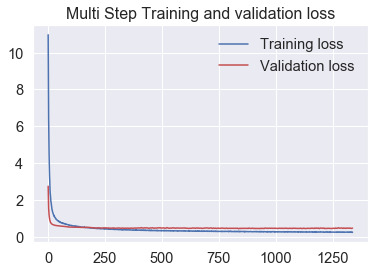

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn/assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01053: early stopping
Run #1 : val_loss = 0.4331943392753601


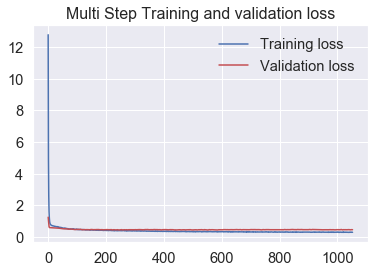

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn/assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn/assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02134: early stopping
Run #2 : val_loss = 0.38804763555526733


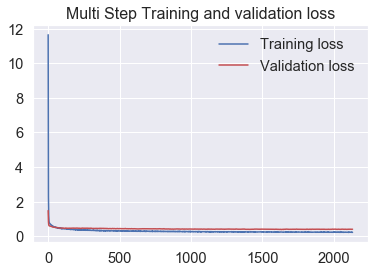

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn/assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn/assets


 
Final val_loss = 0.38804763555526733
Mean asbolute Error in people : 5426.8988835925775
 
CPU times: user 20min 59s, sys: 7min 27s, total: 28min 27s
Wall time: 13min 1s


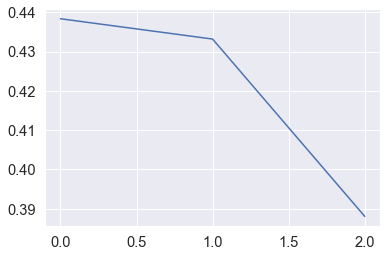

In [101]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.5)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.1)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [102]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  2615.724974695734
Val. Mean Error  [nb of cases]:  5426.898849968116
Val. Mean nb cases  [nb of cases]:  12943.408814589666
Val. Mean Relative Error [%]:  41.927894944112225


### Eval

In [103]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [104]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

CPU times: user 1.47 s, sys: 311 ms, total: 1.78 s
Wall time: 2.14 s


In [105]:
# online version before 24/06/2021: 
#Train Mean Error  [nb of cases]:  4796.392175023473
#Val. Mean Error  [nb of cases]:  5321.471272441916
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.14513288352582
# new 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  2615.724974695734
Val. Mean Error  [nb of cases]:  5426.898849968116
Val. Mean nb cases  [nb of cases]:  12943.408814589666
Val. Mean Relative Error [%]:  41.927894944112225


In [106]:
multi_step_model.predict(x_val_multi)

array([[-7.51479328e-01, -7.37219095e-01, -7.35424697e-01,
        -7.46081233e-01, -7.25991726e-01, -7.39536881e-01,
        -7.38059103e-01],
       [-7.27533162e-01, -7.16580391e-01, -7.20989108e-01,
        -7.56748676e-01, -7.68158436e-01, -6.79434359e-01,
        -7.27222443e-01],
       [-6.89045310e-01, -6.76570535e-01, -6.79808795e-01,
        -7.09055781e-01, -6.91890717e-01, -6.41756177e-01,
        -6.82477117e-01],
       [-6.90685153e-01, -6.75082088e-01, -6.72457755e-01,
        -6.82191014e-01, -6.44607842e-01, -6.61440432e-01,
        -6.80756450e-01],
       [-7.08979666e-01, -6.99746430e-01, -6.94567502e-01,
        -7.06139326e-01, -6.72324419e-01, -6.94625854e-01,
        -7.14444041e-01],
       [-6.87702835e-01, -6.78779602e-01, -6.69610262e-01,
        -6.81000590e-01, -6.43957436e-01, -6.66243315e-01,
        -6.87589288e-01],
       [-6.28886342e-01, -6.47759199e-01, -6.49330676e-01,
        -6.57524824e-01, -6.21283293e-01, -7.02044845e-01,
        -7.4677515

In [107]:
y_val_multi_pred.shape[0]

94

In [108]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

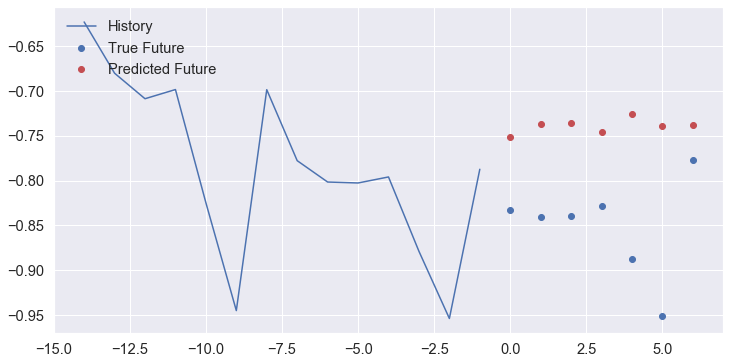

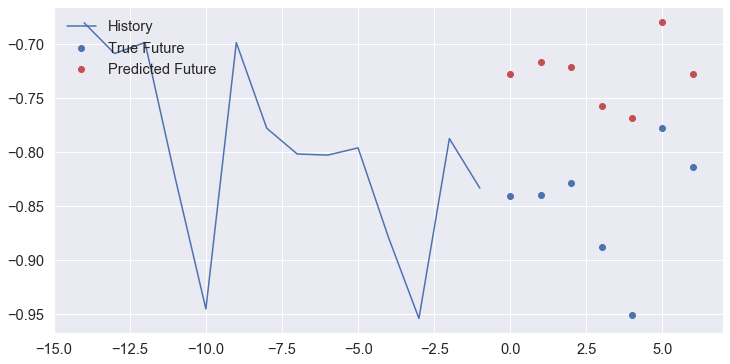

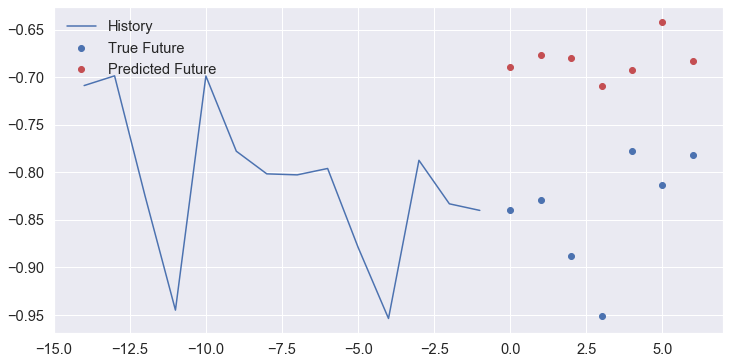

In [109]:
for x, y in val_data_multi.take(1):
    for I in range(3):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [110]:
nb_period_plot = 23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [111]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [112]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [113]:
TRAIN_SPLIT

405

In [114]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [115]:
df_feat_fr.shape

(506, 15)

In [116]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 170 ms, sys: 8.52 ms, total: 178 ms
Wall time: 566 ms


In [117]:
df_feat_fr.date.min()

'2020-05-13'

In [118]:
df_feat_fr.date.max()

'2021-09-30'

In [119]:
df_feat_fr.pos.std()

13235.89723814491

In [120]:
data_std[4]

13985.13580897636

In [121]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2021-04-22'

In [122]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date   pos  nb_cases
2021-10-01  2021-10-01  5909   6943469
2021-10-02  2021-10-02  5337   6948806
2021-10-03  2021-10-03  5024   6953830
2021-10-04  2021-10-04  6378   6960208
2021-10-05  2021-10-05  6690   6966898
2021-10-06  2021-10-06  6006   6972904
2021-10-07  2021-10-07  5423   6978327

In [123]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2021-06-22'

In [124]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2021-04-22  283.746667  2021-04-22  292.561667  50.166667  86.600000     0.0   
2021-04-23  283.678333  2021-04-23  294.163333  43.133333  78.133333     0.0   
2021-04-24  283.658333  2021-04-24  294.821667  43.350000  74.683333     0.0   
2021-04-25  284.916667  2021-04-25  293.375000  48.416667  76.850000     0.0   
2021-04-26  285.018333  2021-04-26  291.768333  52.916667  79.216667     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-09-26  289.327966  2021-09-26  295.911017  63.152542  93.118644     0.0   
2021-09-27  287.765000  2021-09-27  295.293333  59.216667  92.000000     0.0   
2021-09-28  286.375000  2021-09-28  293.993333  58.983333  90.233333     0.0   
2021-09-29  286.875000  2021-09-29  293.856667  55.383333  88.766667     0.0   
2021-09-30  284.388333  2021-09-30  292.543333  57.416667  88.200000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2021-04-22  27917  43.519003  329666  46.492150        4   5081031   396261.0   
2021-04-23  28295  43.106450  376187  46.085061        5   5109326   386760.0   
2021-04-24  17452  42.852682  222290  45.934810        6   5126778   380226.0   
2021-04-25   3612  44.863511   48853  48.230139        0   5130390   378851.0   
2021-04-26  34124  43.594919  405635  47.223378        1   5164514   366828.0   
...           ...        ...     ...        ...      ...       ...        ...   
2021-09-26   1114  41.244165  100587  42.809677        0   6914879    86104.0   
2021-09-27   7466  40.135548  556021  43.227554        1   6922345    81997.0   
2021-09-28   5443  40.472717  472517  41.694517        2   6927788    79168.0   
2021-09-29   4971  39.492456  422979  42.556555        3   6932759    76406.0   
2021-09-30   4801  40.963549  511877  39.266591        4   6937560    74104.0   

                  Rt  rate_pos  
date                            
2021-04-22  0.879943  8.468268  
2021-04-23  0.862620  7.521525  
2021-04-24  0.849994  7.851005  
2021-04-25  0.847087  7.393609  
2021-04-26  0.832722  8.412489  
...              ...       ...  
2021-09-26  0.549098  1.107499  
2021-09-27  0.560663  1.342755  
2021-09-28  0.572139  1.151916  
2021-09-29  0.582932  1.175236  
2021-09-30  0.591828  0.937921  

[162 rows x 15 columns]

### Figure

In [125]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [126]:
nb_period_plot

23

In [127]:
dataset.shape

(506, 9)

In [128]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[331 - 345]
[338 - 352]
[345 - 359]
[352 - 366]
[359 - 373]
[366 - 380]
[373 - 387]
[380 - 394]
[387 - 401]
[394 - 408]
[401 - 415]
[408 - 422]
[415 - 429]
[422 - 436]
[429 - 443]
[436 - 450]
[443 - 457]
[450 - 464]
[457 - 471]
[464 - 478]
[471 - 485]
[478 - 492]
[485 - 499]
23
CPU times: user 1.16 s, sys: 41.7 ms, total: 1.2 s
Wall time: 2.64 s


array([[22176.605 , 12666.697 ,  5626.0483, 28133.814 , 23809.676 ,
        22304.496 , 22703.45  , 18236.922 ,  8905.48  ,  2946.3691,
        25596.082 , 19274.115 , 17802.016 , 17710.824 , 14319.611 ,
         7214.4067,  2975.5088, 19716.46  , 15478.447 , 14219.62  ,
        14489.626 , 11656.222 ,  6400.917 ,  2720.0977, 16029.23  ,
        13149.929 , 12171.73  , 12163.621 ,  9774.609 ,  6382.439 ,
         3669.8047, 12542.381 , 10928.399 , 10078.685 ,  9986.973 ,
         8718.131 ,  6318.693 ,  4484.2246, 10897.992 ,  9747.714 ,
         9092.078 ,  8854.229 ,  5644.0537,  5061.9326,  4129.323 ,
         6180.107 ,  6314.7275,  5681.504 ,  5474.6045,  4323.749 ,
         4313.593 ,  4093.543 ,  4574.6357,  4971.118 ,  4694.8   ,
         4428.4873,  3431.4766,  3644.1973,  3677.1152,  3519.29  ,
         3943.7783,  3805.1826,  3586.7158,  4057.4424,  4275.6523,
         4312.3545,  4176.2324,  4701.839 ,  4466.4326,  4196.296 ,
         4676.6543,  4617.6426,  4261.634 ,  507

In [129]:
y_pos_pred.shape

(1, 161)

In [130]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

161
2021-04-22
2021-09-30


date    pos  nb_cases
2021-04-23  2021-04-23  22176   5103207
2021-04-24  2021-04-24  12666   5115873
2021-04-25  2021-04-25   5626   5121499
2021-04-26  2021-04-26  28133   5149632
2021-04-27  2021-04-27  23809   5173441
...                ...    ...       ...
2021-09-26  2021-09-26   5111   6919491
2021-09-27  2021-09-27   5966   6925457
2021-09-28  2021-09-28   6496   6931953
2021-09-29  2021-09-29   6163   6938116
2021-09-30  2021-09-30   5762   6943878

[161 rows x 3 columns]

### Figure all past 

In [131]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [132]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [133]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()

### Features Importance

#### for all seq

In [134]:
arr_grads = grads_by_features(x_train_multi, multi_step_model)


In [135]:
df_grads = pd.DataFrame(data=arr_grads, columns=list_feat)
df_grads

T_min     T_max     H_min     H_max       pos      test   day_num  \
0   -0.009532 -0.003096 -0.013546  0.021239  0.205970 -0.021337 -0.022080   
1   -0.020062  0.009367 -0.020040  0.017265  0.189023  0.003433 -0.007500   
2   -0.005140 -0.007965 -0.021135  0.015542  0.175441 -0.003903 -0.020065   
3   -0.007389  0.004588 -0.025551  0.019181  0.180666 -0.005691 -0.024102   
4   -0.010233  0.005426 -0.023761  0.015275  0.173287 -0.009313 -0.018860   
..        ...       ...       ...       ...       ...       ...       ...   
386  0.008291 -0.019235 -0.030901  0.021730  0.177252 -0.027029  0.001452   
387 -0.000363 -0.022759 -0.034611  0.014463  0.197920 -0.063000 -0.006385   
388  0.014685 -0.020698 -0.044557  0.024807  0.172607 -0.015089  0.011668   
389 -0.000740 -0.006848 -0.033580  0.024999  0.182337 -0.035369  0.015714   
390  0.000317 -0.013604 -0.044441  0.035590  0.232155 -0.035943 -0.024994   

      age_pos  age_test  
0    0.009402 -0.041150  
1    0.010351 -0.032821  
2   -0.006154 -0.020988  
3    0.003877 -0.028620  
4   -0.001877 -0.029727  
..        ...       ...  
386 -0.011884 -0.012975  
387 -0.012223 -0.018662  
388  0.005678 -0.001916  
389 -0.004867  0.002018  
390 -0.000261 -0.011220  

[391 rows x 9 columns]

(-0.6, 0.6)

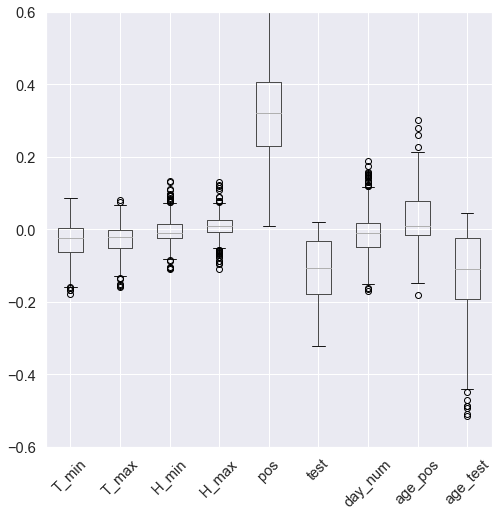

In [136]:
fig = plt.figure(figsize=(8, 8))
boxplot = df_grads.boxplot(rot=45)
ax = fig.gca()
ax.set_ylim([-0.6, 0.6])

#### By days before

In [137]:
sum_grads = grads_by_days(x_train_multi, multi_step_model)

In [138]:
df_time_grads = pd.DataFrame(data=sum_grads, columns=list_feat, 
                             index = [ -I for I in range(14, 0, -1)])
df_time_grads

T_min         T_max         H_min         H_max           pos  \
-14 -1.759468e-08 -2.035004e-08  4.876769e-09  4.264816e-08 -8.484538e-09   
-13 -4.953266e-08 -1.985877e-06  2.462539e-06 -2.503739e-06 -6.411808e-06   
-12  4.966382e-07 -4.577740e-07 -7.344765e-07  2.185235e-07  1.394887e-06   
-11 -1.555118e-06 -3.052214e-06  1.034416e-05 -3.511059e-06 -3.151194e-05   
-10  2.788474e-06 -5.630027e-06 -2.382551e-06  4.503994e-07  1.251420e-05   
-9   4.336595e-05 -4.474177e-06 -2.517290e-05  4.982448e-05  3.689862e-04   
-8  -4.271799e-08 -4.631017e-08  3.389878e-08 -6.723326e-09 -5.173257e-08   
-7  -1.338463e-05  5.204960e-06  2.310748e-05 -1.305505e-05 -1.454325e-04   
-6  -1.921791e-06  1.998721e-05  1.560839e-05  6.185494e-07 -4.102358e-05   
-5   5.650938e-04 -3.409177e-04 -7.304368e-04  6.411751e-04  3.068701e-03   
-4   4.194274e-06  5.484929e-05  1.290285e-05  5.500357e-06 -8.922013e-05   
-3  -1.536770e-04  2.136024e-04 -6.746054e-04  4.507296e-04  1.772548e-03   
-2  -1.014445e-04  3.940757e-05  7.267959e-05  3.584037e-05  3.398315e-04   
-1  -3.325042e-04 -4.635703e-04 -2.950510e-04  1.090041e-04  3.062131e-03   

             test       day_num       age_pos      age_test  
-14 -1.231704e-09 -3.778608e-08  6.001681e-08  1.160527e-08  
-13  3.323435e-06  1.553966e-06 -6.689874e-07 -8.102873e-08  
-12 -3.624602e-07  2.733671e-07 -3.543450e-07  3.049846e-07  
-11  1.487673e-05 -3.974182e-06 -2.019884e-06 -3.749807e-06  
-10 -3.295045e-06  5.701737e-07 -1.463533e-06 -1.572281e-07  
-9  -8.028618e-05  2.766663e-05 -1.964805e-05 -6.650957e-05  
-8   2.582718e-08 -1.700704e-07  1.844012e-08 -7.863763e-08  
-7   7.429600e-06  3.483375e-05  1.237904e-05  3.624822e-06  
-6   1.069970e-06 -4.337258e-06  1.244159e-06  1.409583e-06  
-5  -7.387926e-04 -4.674397e-04 -6.212483e-05 -1.655292e-04  
-4  -3.752193e-06 -2.029894e-05  4.348959e-06  6.240450e-06  
-3   1.341279e-04  3.858338e-04  3.078906e-04  2.581272e-04  
-2   4.792675e-05  1.216658e-05 -4.256792e-05 -5.173749e-05  
-1  -6.692616e-04 -8.615821e-04 -2.064281e-04 -3.836022e-04

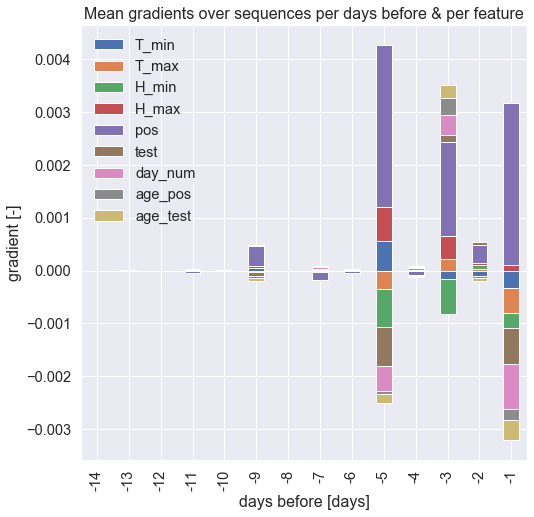

In [139]:
fig, ax = plt.subplots(figsize=(8, 8))
g_bar = df_time_grads.plot(kind='bar', stacked=True, ax=ax,
            title="Mean gradients over sequences per days before & per feature")
plt.xlabel("days before [days]")
plt.ylabel("gradient [-]");

=> Big impact of "pos", "test" and "age_test" but one day before (a little 5 days before) , and a little less 9 and 3 days before.  
But why not have an impact on the even days before?  
  
We can try to change input to see prediction on even days : 

In [140]:
i_seq = 123
x_mod = x_train_multi[i_seq].copy()

x_mod[0] = x_mod[0]*0.5
x_mod[2] = x_mod[2]*0.5
x_mod[4] = x_mod[4]*0.5
x_mod[6] = x_mod[6]*0.5
x_mod[10] = x_mod[10]*0.5
x_mod[12] = x_mod[12]*0.5
x_mod

array([[ 3.72222075e-01,  8.32173106e-01, -8.39730757e-01,
        -1.46815153e-01, -4.35597053e-01, -5.88506789e-01,
        -7.49923802e-01, -1.82971675e-01, -1.64272383e-01],
       [ 1.17423891e+00,  2.08358240e+00, -1.97643577e+00,
        -1.49372601e+00,  5.78637283e-02,  2.83239410e-01,
        -1.00030955e+00, -7.96184667e-01, -1.01297751e+00],
       [ 7.46837333e-01,  8.78912275e-01, -7.44344985e-01,
        -6.32247123e-01, -1.29340146e-02,  1.13214970e-01,
        -2.50385743e-01, -4.78689438e-01, -6.78861991e-01],
       [ 1.33488809e+00,  1.65903494e+00, -1.20351601e+00,
        -6.98156948e-01, -3.33044961e-02,  1.15319158e-01,
        -1.23342731e-03, -1.00302507e+00, -1.51849401e+00],
       [ 6.59180732e-01,  7.48657148e-01, -7.62944023e-01,
        -4.95235034e-01, -8.75100194e-03,  4.65563201e-02,
         2.49152316e-01, -4.75764967e-01, -6.34951715e-01],
       [ 1.19612445e+00,  1.39417965e+00, -1.02061133e+00,
        -1.52518919e+00, -4.76768986e-02,  9.420131

In [141]:
x_train_multi[i_seq]

array([[ 7.44444149e-01,  1.66434621e+00, -1.67946151e+00,
        -2.93630306e-01, -8.71194107e-01, -1.17701358e+00,
        -1.49984760e+00, -3.65943351e-01, -3.28544767e-01],
       [ 1.17423891e+00,  2.08358240e+00, -1.97643577e+00,
        -1.49372601e+00,  5.78637283e-02,  2.83239410e-01,
        -1.00030955e+00, -7.96184667e-01, -1.01297751e+00],
       [ 1.49367467e+00,  1.75782455e+00, -1.48868997e+00,
        -1.26449425e+00, -2.58680292e-02,  2.26429940e-01,
        -5.00771486e-01, -9.57378876e-01, -1.35772398e+00],
       [ 1.33488809e+00,  1.65903494e+00, -1.20351601e+00,
        -6.98156948e-01, -3.33044961e-02,  1.15319158e-01,
        -1.23342731e-03, -1.00302507e+00, -1.51849401e+00],
       [ 1.31836146e+00,  1.49731430e+00, -1.52588805e+00,
        -9.90470069e-01, -1.75020039e-02,  9.31126402e-02,
         4.98304632e-01, -9.51529934e-01, -1.26990343e+00],
       [ 1.19612445e+00,  1.39417965e+00, -1.02061133e+00,
        -1.52518919e+00, -4.76768986e-02,  9.420131

In [142]:
seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)
seq_mod = tf.Variable(x_mod[np.newaxis,:,:], dtype=tf.float32)
predictions = multi_step_model(seq)
predictions_mod = multi_step_model(seq_mod)
try:
    np.testing.assert_almost_equal(predictions.numpy(), 
                               predictions_mod.numpy(), decimal=3)
    print("Even days have no impact on prediction !")
except:
    print("It is not same result, it is normal.")

It is not same result, it is normal.


In [143]:
predictions

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.8131885 ,  0.10898304, -0.08100682, -0.14140838, -0.11290556,
        -0.10708058, -0.48014042]], dtype=float32)>

In [144]:
predictions_mod

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.84199363,  0.14615929, -0.06863037, -0.12910089, -0.10048071,
        -0.09289742, -0.48731577]], dtype=float32)>

In [145]:
x_mod[0] = x_mod[0]*2
x_mod

array([[ 7.44444149e-01,  1.66434621e+00, -1.67946151e+00,
        -2.93630306e-01, -8.71194107e-01, -1.17701358e+00,
        -1.49984760e+00, -3.65943351e-01, -3.28544767e-01],
       [ 1.17423891e+00,  2.08358240e+00, -1.97643577e+00,
        -1.49372601e+00,  5.78637283e-02,  2.83239410e-01,
        -1.00030955e+00, -7.96184667e-01, -1.01297751e+00],
       [ 7.46837333e-01,  8.78912275e-01, -7.44344985e-01,
        -6.32247123e-01, -1.29340146e-02,  1.13214970e-01,
        -2.50385743e-01, -4.78689438e-01, -6.78861991e-01],
       [ 1.33488809e+00,  1.65903494e+00, -1.20351601e+00,
        -6.98156948e-01, -3.33044961e-02,  1.15319158e-01,
        -1.23342731e-03, -1.00302507e+00, -1.51849401e+00],
       [ 6.59180732e-01,  7.48657148e-01, -7.62944023e-01,
        -4.95235034e-01, -8.75100194e-03,  4.65563201e-02,
         2.49152316e-01, -4.75764967e-01, -6.34951715e-01],
       [ 1.19612445e+00,  1.39417965e+00, -1.02061133e+00,
        -1.52518919e+00, -4.76768986e-02,  9.420131

In [146]:

seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)

In [147]:
x_train_multi[i_seq]

array([[ 7.44444149e-01,  1.66434621e+00, -1.67946151e+00,
        -2.93630306e-01, -8.71194107e-01, -1.17701358e+00,
        -1.49984760e+00, -3.65943351e-01, -3.28544767e-01],
       [ 1.17423891e+00,  2.08358240e+00, -1.97643577e+00,
        -1.49372601e+00,  5.78637283e-02,  2.83239410e-01,
        -1.00030955e+00, -7.96184667e-01, -1.01297751e+00],
       [ 1.49367467e+00,  1.75782455e+00, -1.48868997e+00,
        -1.26449425e+00, -2.58680292e-02,  2.26429940e-01,
        -5.00771486e-01, -9.57378876e-01, -1.35772398e+00],
       [ 1.33488809e+00,  1.65903494e+00, -1.20351601e+00,
        -6.98156948e-01, -3.33044961e-02,  1.15319158e-01,
        -1.23342731e-03, -1.00302507e+00, -1.51849401e+00],
       [ 1.31836146e+00,  1.49731430e+00, -1.52588805e+00,
        -9.90470069e-01, -1.75020039e-02,  9.31126402e-02,
         4.98304632e-01, -9.51529934e-01, -1.26990343e+00],
       [ 1.19612445e+00,  1.39417965e+00, -1.02061133e+00,
        -1.52518919e+00, -4.76768986e-02,  9.420131

In [148]:
x = tf.constant([3.0, 2.0])
with tf.GradientTape() as g:
    g.watch(x)
    y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([6. 4.], shape=(2,), dtype=float32)


In [149]:
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([9., 4.], dtype=float32)>

In [150]:
x

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([3., 2.], dtype=float32)>

In [151]:
#inputs = tf.constant([3.0, 2.0])
inputs = tf.Variable(np.array([1.0, 2.0])[np.newaxis,:], dtype=tf.float32)
a = tf.keras.layers.Dense(3)


In [152]:
with tf.GradientTape() as tape:
    result = a(inputs)
grads = tape.gradient(result, inputs)
grads

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.7173083, -0.379555 ]], dtype=float32)>

In [153]:
a.kernel

<tf.Variable 'dense_1/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[-0.20816207,  0.504933  ,  0.42053735],
       [-0.06536651, -0.5526084 ,  0.23841989]], dtype=float32)>

In [154]:
result

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.33889508, -0.60028374,  0.89737713]], dtype=float32)>

In [155]:
0.86197734 -0.08069324 + 0.32413316

1.10541726

In [156]:
0.40406668 +  0.89749837 + 0.95976377

2.26132882

In [157]:
0.3729093 + -0.51952934 + -0.27287823

-0.41949826999999995

In [158]:
result[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.33889508, -0.60028374,  0.89737713], dtype=float32)>

In [159]:
np.array([3.0, 2.0])[np.newaxis,:]

array([[3., 2.]])